## 1. Theory: OLS with Newey–West (HAC) standard errors

In the paper, the spillover index (or its log-return) is regressed on a set of exogenous variables (fuel prices, loads, RES shares, …) using OLS and Newey–West robust standard errors to correct for heteroskedasticity and autocorrelation:

$$
S_t = \beta_0 + \beta_1 x_{1,t} + \dots + \beta_K x_{K,t} + \varepsilon_t,
$$

where

* ($S_t$) is the endogenous variable (e.g. total spillover, or “to others”, “from others”, etc.),
* ($x_{k,t}$) are exogenous regressors (here: CO₂/EUA, coal, TTF, …),
* ($\varepsilon_t$) is an error term that may be serially correlated and heteroskedastic.

OLS still gives unbiased/consistent point estimates under standard conditions, but the usual covariance estimator ($ \hat{\sigma}^2(X'X)^{-1}$) is wrong when errors are autocorrelated or heteroskedastic. Newey–West (HAC) replaces it with

$$
\widehat{\mathrm{Var}}*{\text{NW}}(\hat\beta)
= (X'X)^{-1} \left( \sum*{|\ell|\le L} w_\ell \Gamma_\ell \right) (X'X)^{-1},
$$

where

* ($\Gamma_\ell = \frac{1}{T} \sum_{t=\ell+1}^T u_t u_{t-\ell}' X_t' X_{t-\ell}$) are lag-($\ell$) autocovariances of residuals,
* ($w_\ell$) are Bartlett weights,
* ($L$) is the chosen truncation lag (“maxlags” in `statsmodels`).

In practice we:

1. Estimate OLS: ($\hat\beta = (X'X)^{-1}X'Y$).
2. Compute Newey–West robust covariance with chosen lag ($L$).
3. Use this covariance for t-stats, p-values and confidence intervals.

The code below implements exactly that via `statsmodels` (`cov_type="HAC"` and `cov_kwds={"maxlags": L}`), and runs *one regression per endogenous series*.





In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

OUT_DIR = Path("../data/endogenous/prices/differenced")
endog_path = OUT_DIR / "endogenous_tsi_diff.parquet"
endog_levels_path = "../data/endogenous/prices/levels/endogenous_tsi_levels.parquet"
exog_path  = Path("../data/exogenous/all_exog_ready.parquet")

RESULTS_DIR = Path("../data/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Endog file:", endog_path)
print("Exog file :", exog_path)
print("Results ->", RESULTS_DIR)


Endog file: ..\data\endogenous\prices\differenced\endogenous_tsi_diff.parquet
Exog file : ..\data\exogenous\all_exog_ready.parquet
Results -> ..\data\results


In [2]:
# Load endogenous (endog)

endog_raw = pd.read_parquet(endog_path) # differenced
#endog_raw = pd.read_parquet(endog_levels_path)
display(endog_raw.head())

endog_raw["date"] = pd.to_datetime(endog_raw["date"])
endog = endog_raw.set_index("date").sort_index()

print("Endog shape:", endog_raw.shape)
print("Endog columns:", list(endog_raw.columns))

,date,d_tsi_mhar_recov_neg,d_tsi_mhar_recov_pos,d_tsi_mhar_recov,d_tsi_mhar_revar
0,2022-05-21,0.565159,0.353851,0.318845,0.464115
1,2022-05-22,0.028779,0.053486,0.018242,0.090025
2,2022-05-23,0.017773,0.001561,0.009926,-0.035204
3,2022-05-24,-0.010183,-0.026224,-0.020802,-0.033416
4,2022-05-25,0.021521,-0.015650,-0.001137,-0.004788


Endog shape: (1076, 5)
Endog columns: ['date', 'd_tsi_mhar_recov_neg', 'd_tsi_mhar_recov_pos', 'd_tsi_mhar_recov', 'd_tsi_mhar_revar']


In [3]:
# Load exogenous (exog) 

exog_raw = pd.read_parquet(exog_path)
display(exog_raw.head())

exog_raw["date"] = pd.to_datetime(exog_raw["date"])
exog = exog_raw.set_index("date").sort_index()

print("Exog shape:", exog_raw.shape)
print("Exog columns:", list(exog_raw.columns))

,date,co2,load_energy_mw_es,load_energy_mw_fr,load_energy_mw_pt,flow_net_mw_ES_FR,flow_net_mw_ES_PT,psi_eur_pts,d_TTF,d_coal,d_cac_eur_pts,d_ibex_eur_pts,iberian_exception
0,2021-05-22,51.29,24528.333333,43120.833333,4970.875000,-2942.129167,1609.212500,5271.569824,0.000000,0.000000,0.000000,0.000000,0
1,2021-05-23,51.29,22572.791667,41512.500000,4588.625000,-2921.383333,1017.291667,5271.569824,0.000000,0.000000,0.000000,0.000000,0
2,2021-05-24,52.68,26303.541667,41808.333333,5414.458333,-3279.625000,1429.829167,5221.720215,-0.030001,-0.042563,22.080078,1.500000,0
3,2021-05-25,51.24,27226.625000,49120.833333,5588.791667,-2847.470833,400.925000,5221.720215,1.430000,0.004210,-18.220215,3.200195,0
4,2021-05-26,52.81,27430.125000,48747.916667,5594.833333,-3178.591667,666.687500,5220.339844,0.240000,0.508413,1.330078,-11.799805,0


Exog shape: (1440, 13)
Exog columns: ['date', 'co2', 'load_energy_mw_es', 'load_energy_mw_fr', 'load_energy_mw_pt', 'flow_net_mw_ES_FR', 'flow_net_mw_ES_PT', 'psi_eur_pts', 'd_TTF', 'd_coal', 'd_cac_eur_pts', 'd_ibex_eur_pts', 'iberian_exception']


In [4]:
# Choose which exogenous variables to use:
# - exog_cols = None uses ALL columns in the exog parquet
# - or provide a list, e.g. ["d_eua", "d_coal", "d_ttf"]

exog_cols = None  # <-- change here if you want a subset

if exog_cols is None:
    exog_names = list(exog.columns)
else:
    missing = [c for c in exog_cols if c not in exog.columns]
    if missing:
        raise ValueError(f"Missing exogenous columns: {missing}")
    exog_names = exog_cols

endog_names = list(endog.columns)

print("Using", len(endog_names), "endog series:", endog_names)
print("Using", len(exog_names), "exog vars  :", exog_names)

Using 4 endog series: ['d_tsi_mhar_recov_neg', 'd_tsi_mhar_recov_pos', 'd_tsi_mhar_recov', 'd_tsi_mhar_revar']
Using 12 exog vars  : ['co2', 'load_energy_mw_es', 'load_energy_mw_fr', 'load_energy_mw_pt', 'flow_net_mw_ES_FR', 'flow_net_mw_ES_PT', 'psi_eur_pts', 'd_TTF', 'd_coal', 'd_cac_eur_pts', 'd_ibex_eur_pts', 'iberian_exception']


In [5]:
print("endog index type:", type(endog.index), "name:", endog.index.name)
print("exog  index type:", type(exog.index),  "name:", exog.index.name)
print("endog unique dates:", endog.index.is_unique)
print("exog  unique dates:", exog.index.is_unique)


endog index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> name: date
exog  index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> name: date
endog unique dates: True
exog  unique dates: True


In [6]:
# Align endog + exog on the same dates, drop rows with any NA

data = endog.join(exog[exog_names], how="inner")
print("After join:", data.shape)

data = data[endog_names + exog_names].dropna()
print("After dropna:", data.shape)
display(data.head())


After join: (1076, 16)
After dropna: (1076, 16)


,d_tsi_mhar_recov_neg,d_tsi_mhar_recov_pos,d_tsi_mhar_recov,d_tsi_mhar_revar,co2,load_energy_mw_es,load_energy_mw_fr,load_energy_mw_pt,flow_net_mw_ES_FR,flow_net_mw_ES_PT,psi_eur_pts,d_TTF,d_coal,d_cac_eur_pts,d_ibex_eur_pts,iberian_exception
date,,,,,,,,,,,,,,,,
2022-05-21,0.565159,0.353851,0.318845,0.464115,80.02,25161.217391,40113.043478,4998.695652,-1267.886957,1304.791304,5921.160156,0.00,0.000000,0.000000,0.000000,0
2022-05-22,0.028779,0.053486,0.018242,0.090025,80.02,23133.583333,38566.666667,4781.041667,-1280.312500,1758.000000,5921.160156,0.00,0.000000,0.000000,0.000000,0
2022-05-23,0.017773,0.001561,0.009926,-0.035204,78.18,27192.655556,44945.833333,5553.708333,-184.662500,539.587500,6079.509766,-4.61,-6.869052,73.500000,141.299805,0
2022-05-24,-0.010183,-0.026224,-0.020802,-0.033416,80.96,27038.291667,45610.416667,5674.083333,49.637500,236.762500,6130.899902,1.22,-1.999857,-105.600098,5.400391,0
2022-05-25,0.021521,-0.015650,-0.001137,-0.004788,81.03,26666.750000,44310.416667,5743.375000,457.479167,1438.329167,6184.839844,3.57,0.622824,45.500000,129.000000,0


In [7]:
# quick sanity checks

print("Date range:", data.index.min(), "->", data.index.max())
print("\nMissing values per column (should be 0 now):")
display(data.isna().sum().sort_values(ascending=False).head(15))


Date range: 2022-05-21 00:00:00 -> 2025-04-30 00:00:00

Missing values per column (should be 0 now):


d_tsi_mhar_recov_neg    0
d_tsi_mhar_recov_pos    0
d_tsi_mhar_recov        0
d_tsi_mhar_revar        0
co2                     0
load_energy_mw_es       0
load_energy_mw_fr       0
load_energy_mw_pt       0
flow_net_mw_ES_FR       0
flow_net_mw_ES_PT       0
psi_eur_pts             0
d_TTF                   0
d_coal                  0
d_cac_eur_pts           0
d_ibex_eur_pts          0
dtype: int64

In [8]:
# Run OLS + Newey–West (HAC) for each endogenous series
# This prints the default statsmodels summary output.

nw_lags = 10  # <-- maxlags for HAC

results = {}
X = sm.add_constant(data[exog_names])

for y_name in endog_names:
    y = data[y_name]
    model = sm.OLS(y, X)
    res = model.fit(cov_type="HAC", cov_kwds={"maxlags": nw_lags})
    results[y_name] = res

    print("\n" + "#" * 110)
    print(f"OLS + Newey–West (HAC) — ENDOG = {y_name}  |  maxlags={nw_lags}")
    print("#" * 110)
    print(res.summary())



##############################################################################################################
OLS + Newey–West (HAC) — ENDOG = d_tsi_mhar_recov_neg  |  maxlags=10
##############################################################################################################
                             OLS Regression Results                             
Dep. Variable:     d_tsi_mhar_recov_neg   R-squared:                       0.037
Model:                              OLS   Adj. R-squared:                  0.026
Method:                   Least Squares   F-statistic:                     3.799
Date:                  Tue, 16 Dec 2025   Prob (F-statistic):           1.10e-05
Time:                          20:04:03   Log-Likelihood:                 185.52
No. Observations:                  1076   AIC:                            -345.0
Df Residuals:                      1063   BIC:                            -280.3
Df Model:                            12                     

In [9]:
# Build a tidy coefficient table

coef_rows = []

for y_name, res in results.items():
    ci = res.conf_int()
    for var in ["const"] + exog_names:
        coef_rows.append({
            "endog": y_name,
            "variable": var,
            "coef": res.params.get(var, np.nan),
            "std_err": res.bse.get(var, np.nan),
            "t": res.tvalues.get(var, np.nan),
            "pval": res.pvalues.get(var, np.nan),
            "ci_low":  ci.loc[var, 0] if var in ci.index else np.nan,
            "ci_high": ci.loc[var, 1] if var in ci.index else np.nan,
        })

coef_df = pd.DataFrame(coef_rows)
display(coef_df.head(20))
print("coef_df shape:", coef_df.shape)


,endog,variable,coef,std_err,t,pval,ci_low,ci_high
0,d_tsi_mhar_recov_neg,const,4.578497e-01,0.199009,2.300653,0.021411,0.067800,8.478994e-01
1,d_tsi_mhar_recov_neg,co2,-2.082591e-04,0.000790,-0.263606,0.792084,-0.001757,1.340189e-03
2,d_tsi_mhar_recov_neg,load_energy_mw_es,1.167121e-06,0.000004,0.259930,0.794918,-0.000008,9.967615e-06
3,d_tsi_mhar_recov_neg,load_energy_mw_fr,-7.423003e-07,0.000001,-0.625810,0.531439,-0.000003,1.582497e-06
4,d_tsi_mhar_recov_neg,load_energy_mw_pt,-1.815729e-05,0.000025,-0.725135,0.468369,-0.000067,3.091995e-05
5,d_tsi_mhar_recov_neg,flow_net_mw_ES_FR,-8.914503e-06,0.000005,-1.809901,0.070311,-0.000019,7.391193e-07
6,d_tsi_mhar_recov_neg,flow_net_mw_ES_PT,-2.609284e-05,0.000009,-2.852426,0.004339,-0.000044,-8.163880e-06
7,d_tsi_mhar_recov_neg,psi_eur_pts,-4.516389e-05,0.000028,-1.618085,0.105644,-0.000100,9.542521e-06
8,d_tsi_mhar_recov_neg,d_TTF,-2.770746e-03,0.001103,-2.512624,0.011984,-0.004932,-6.094349e-04
9,d_tsi_mhar_recov_neg,d_coal,1.179616e-06,0.001222,0.000965,0.999230,-0.002394,2.395992e-03


coef_df shape: (52, 8)


In [10]:
# Model-level summary table 

model_rows = []
for y_name, res in results.items():
    model_rows.append({
        "endog": y_name,
        "nobs": int(res.nobs),
        "r2": res.rsquared,
        "adj_r2": res.rsquared_adj,
        "f_stat": getattr(res, "fvalue", np.nan),
        "f_pval": getattr(res, "f_pvalue", np.nan),
        "aic": res.aic,
        "bic": res.bic,
        "dw": sm.stats.stattools.durbin_watson(res.resid),
        "nw_maxlags": nw_lags,
    })

model_df = pd.DataFrame(model_rows).sort_values("endog").reset_index(drop=True)
display(model_df)


,endog,nobs,r2,adj_r2,f_stat,f_pval,aic,bic,dw,nw_maxlags
0,d_tsi_mhar_recov,1076,0.036779,0.025906,3.223456,0.000144,-724.847936,-660.094861,1.744971,10
1,d_tsi_mhar_recov_neg,1076,0.036521,0.025645,3.798881,0.000011,-345.041381,-280.288306,1.761831,10
2,d_tsi_mhar_recov_pos,1076,0.040557,0.029726,3.769948,0.000012,-702.215029,-637.461954,1.846546,10
3,d_tsi_mhar_revar,1076,0.027017,0.016033,2.985688,0.000404,-518.975683,-454.222609,1.816465,10


In [11]:
# Save outputs (CSV) + one text file with all summaries

coef_path = RESULTS_DIR / "nw_regression_coefficients.csv"
model_path = RESULTS_DIR / "nw_regression_model_stats.csv"
txt_path = RESULTS_DIR / "nw_model_summaries.txt"

coef_df.to_csv(coef_path, index=False)
model_df.to_csv(model_path, index=False)

with txt_path.open("w", encoding="utf-8") as f:
    for y_name, res in results.items():
        f.write("=" * 100 + "\n")
        f.write(f"ENDOG: {y_name} | maxlags={nw_lags}\n")
        f.write("=" * 100 + "\n\n")
        f.write(res.summary().as_text())
        f.write("\n\n")

print("Saved:", coef_path)
print("Saved:", model_path)
print("Saved:", txt_path)


Saved: ..\data\results\nw_regression_coefficients.csv
Saved: ..\data\results\nw_regression_model_stats.csv
Saved: ..\data\results\nw_model_summaries.txt


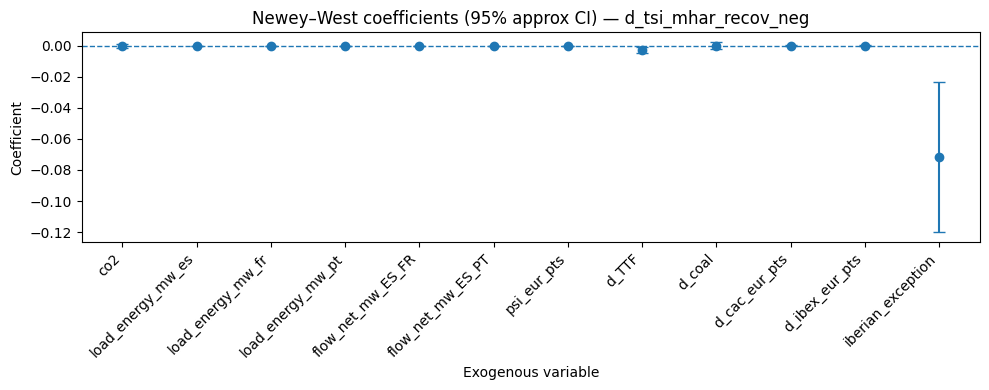

,endog,variable,coef,std_err,t,pval,ci_low,ci_high
12,d_tsi_mhar_recov_neg,iberian_exception,-7.181814e-02,0.024648,-2.913729,0.003571,-0.120128,-2.350858e-02
6,d_tsi_mhar_recov_neg,flow_net_mw_ES_PT,-2.609284e-05,0.000009,-2.852426,0.004339,-0.000044,-8.163880e-06
8,d_tsi_mhar_recov_neg,d_TTF,-2.770746e-03,0.001103,-2.512624,0.011984,-0.004932,-6.094349e-04
5,d_tsi_mhar_recov_neg,flow_net_mw_ES_FR,-8.914503e-06,0.000005,-1.809901,0.070311,-0.000019,7.391193e-07
7,d_tsi_mhar_recov_neg,psi_eur_pts,-4.516389e-05,0.000028,-1.618085,0.105644,-0.000100,9.542521e-06
10,d_tsi_mhar_recov_neg,d_cac_eur_pts,-1.050170e-04,0.000126,-0.834437,0.404035,-0.000352,1.416518e-04
4,d_tsi_mhar_recov_neg,load_energy_mw_pt,-1.815729e-05,0.000025,-0.725135,0.468369,-0.000067,3.091995e-05
3,d_tsi_mhar_recov_neg,load_energy_mw_fr,-7.423003e-07,0.000001,-0.625810,0.531439,-0.000003,1.582497e-06
11,d_tsi_mhar_recov_neg,d_ibex_eur_pts,2.529060e-05,0.000087,0.290640,0.771327,-0.000145,1.958407e-04
1,d_tsi_mhar_recov_neg,co2,-2.082591e-04,0.000790,-0.263606,0.792084,-0.001757,1.340189e-03


In [12]:
# Plot coefficients for ONE endogenous series (default style + basic error bars)

endog_to_plot = endog_names[0]  # pick the first one; change to whichever you want

sub = coef_df[(coef_df["endog"] == endog_to_plot) & (coef_df["variable"] != "const")].copy()

z = 1.96  # approx 95% CI
plt.figure(figsize=(10, 4))
plt.errorbar(
    x=sub["variable"],
    y=sub["coef"],
    yerr=z * sub["std_err"],
    fmt="o",
    capsize=4,
)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xticks(rotation=45, ha="right")
plt.title(f"Newey–West coefficients (95% approx CI) — {endog_to_plot}")
plt.xlabel("Exogenous variable")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()

display(sub.sort_values("pval").head(10))
